## Importing libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers
from sklearn.ensemble import RandomForestRegressor

2.6.0


### Get the data and import it using pandas.

In [5]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
col_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

dataset = pd.read_csv(url, names=col_names, na_values='?', comment='\t', sep=' ', skipinitialspace=True)

In [6]:
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


#### Check and drop the missing values

In [7]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [8]:
dataset = dataset.dropna()  # horsepower has 6 missing values

In [10]:
# Origin is Categorical and not numeric. convertiing into one-hot.
dataset['Origin'] = dataset['Origin'].map({1: '1', 2: '2', 3: '3'})
dataset = pd.get_dummies(dataset, columns=['Origin'])
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin_1,Origin_2,Origin_3
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,0,0
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,0,0
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,0,0
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,0,0
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,0,0


In [11]:
# Train-Test split
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [12]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Origin_1,0.624204,0.485101
Origin_2,0.178344,0.383413
Origin_3,0.197452,0.398712


In [13]:
# normalized data is what we will use to train the model.
normalizer = tf.keras.layers.Normalization(axis = -1)
normalizer.adapt(np.array(train_dataset))

In [14]:
# Dictionary for storing comparative performances of models
test_results = {}

def plot_loss(history, title):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.title(title)
  plt.legend()
  plt.grid(True)

In [15]:
# Linear Regression Model
linear_regression_model = tf.keras.Sequential([
  normalizer,
  layers.Dense(units=1)                                               
])

# Compiling Model
linear_regression_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error'
)

In [16]:
# Fit on training data
linear_regression_history = linear_regression_model.fit(
    train_dataset,
    train_labels,
    epochs=100,
    verbose=0,
    validation_split=0.2
)

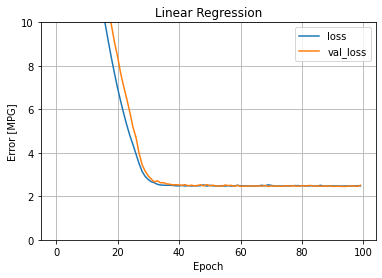

In [17]:
plot_loss(linear_regression_history, 'Linear Regression')

In [18]:
test_results['linear_regression_model'] = linear_regression_model.evaluate(
    test_dataset, test_labels, verbose=0
)

In [19]:
def build_model(norm):
  model = keras.Sequential([
          norm,
          layers.Dense(64, activation='relu'),
          layers.Dense(32, activation='relu'),
          layers.Dense(16, activation='relu'),
          layers.Dense(4, activation='relu'),
          layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
    optimizer=tf.keras.optimizers.Adam(0.001)
  )
  return model

In [20]:
dense_model= build_model(normalizer)
dense_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 9)                 19        
_________________________________________________________________
dense_1 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 68        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 3,340
Trainable params: 3,321
Non-trainable params: 19
___________________________________________________

In [21]:
# Fitting the model on training data
dense_model_history = dense_model.fit(
    train_dataset,
    train_labels,
    validation_split=0.2,
    verbose=0, 
    epochs=100
)

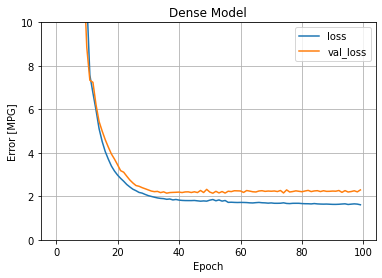

In [22]:
plot_loss(dense_model_history, 'Dense Model')

In [23]:
test_results['dense_model'] = dense_model.evaluate(
    test_dataset, test_labels, verbose=0
)

In [24]:
def build_tut_model(norm):
  model = keras.Sequential([
          norm,
          layers.Dense(64, activation='relu'),
          layers.Dense(64, activation='relu'),
          layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
    optimizer=tf.keras.optimizers.Adam(0.001)
  )
  return model

In [25]:
tut_model= build_model(normalizer)
tut_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 9)                 19        
_________________________________________________________________
dense_6 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_8 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 68        
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 5         
Total params: 3,340
Trainable params: 3,321
Non-trainable params: 19
___________________________________________________

In [26]:
tut_model_history = tut_model.fit(
    train_dataset,
    train_labels,
    validation_split=0.2,
    verbose=0, 
    epochs=100
)

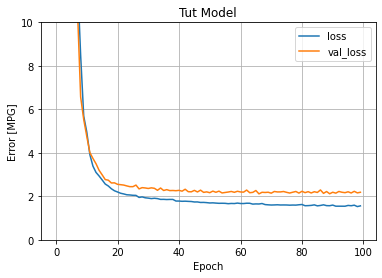

In [27]:
plot_loss(tut_model_history, 'Tut Model')

In [31]:
test_results['tut_model'] = tut_model.evaluate(
    test_dataset, test_labels, verbose=0
)

In [32]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T  # comparing all models.

,Mean absolute error [MPG]
linear_regression_model,2.576010
dense_model,1.684844
tut_model,1.735319


Hence the dense model outperforms the tutorial model and thus will be used in the final deployed endpoint.